# Conditional Data Imputers

This example notebook demonstrates the usage and performance of `GaussianImputer` and `GaussianCopulaImputer` in the context of conditional imputation of Shapley interaction values and model-agnostic explanations. Two Conditional imputations modules are implemented as part of the `student_shapiq` package.

### Gaussian Imputer
For nice-behaving unimodal data, a natural approach is to assume that $x$ stems from a multivariate Gaussian distribution with mean $µ$ and covariance matrix $Σ$. In the present context, this method was first suggested by [(Aas et al. (2021))](https://doi.org/10.1016/j.artint.2021.103502).

### Gaussian Copula Imputer
A generalization of the gaussian approach, also proposed by [(Aas et al. (2021))](https://doi.org/10.1016/j.artint.2021.103502), is to use a Gaussian copula. That is, to represent the marginals of the features by their empirical distributions and then model the dependence structure by a Gaussian distribution.

### Import Modules


In [1]:
from __future__ import annotations

import shapiq
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import shapiq_student
from shapiq_student.gaussian import GaussianImputer
from shapiq_student.copula import GaussianCopulaImputer

print(f"shapiq version: {shapiq.__version__}")
print(f"shapiq_student version: {shapiq_student.__version__}")

shapiq version: 1.3.0
shapiq_student version: 0.4.2


We firstly use California housing dataset for demonstration. Dataset can be found at https://www.kaggle.com/datasets/camnugent/california-housing-prices

In [2]:
X, y = shapiq.load_california_housing()
feature_names = X.columns
X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values,
    test_size=0.25,
    random_state=42,
)
n_features = X_train.shape[1]

print("Feature names:")
print(X.columns.tolist())

Feature names:
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


### Train a Model
We train a random forest regressor on the California housing dataset to explain the model with conditional imputation. The model achieves a relatively good fit in terms of the $R^2$ score.

In [3]:
model = RandomForestRegressor(
    n_estimators=500,
    max_depth=n_features,
    max_features=2 / 3,
    max_samples=2 / 3,
    random_state=42,
)
model.fit(X_train, y_train)
print(f"Train R2: {model.score(X_train, y_train):.4f}")
print(f"Test  R2: {model.score(X_test, y_test):.4f}")

Train R2: 0.7991
Test  R2: 0.7462


### Using multivariate Gaussian or Gaussian Copula Imputer for Explanations
Both Multivariate Gaussian and Gaussian Copula Imputers use the joint distribution of features to estimate missing values, but in different ways. The Multivariate Gaussian Imputer assumes all variables follow a joint Gaussian distribution, modeling both marginals and dependencies parametrically.

##### Gausian Multivariate
A classic and beneficial property of this assumption is that the conditional distributions are also multivariate Gaussian. That is, if

$p(x) = p(x_S,x_{\overline{S}}) = \mathcal{N}_M(µ,Σ)$, where $µ = [µ_S,µ_{\overline{S}}]^T$ and
$$
\Sigma = \begin{bmatrix}
\Sigma_{S,S} & \Sigma_{S,\overline{S}} \\
\Sigma_{\overline{S},S} & \Sigma_{\overline{S},\overline{S}}
\end{bmatrix}
$$
then, $p(x_\overline{S}|x_S = x^{∗}_S) = \mathcal{N}_{|\overline{S}|}(µ_{\overline{S}|S},Σ_{\overline{S}|S})$, where
$µ_{\overline{S}|S} = µ_{\overline{S}} + Σ_{\overline{S}S}Σ_{SS}^{-1}(x^{∗}_S − µ_S)$ and
$Σ_{\overline{S}|S} = Σ_{\overline{SS}}-Σ_{\overline{S}S}Σ_{SS}^{-1}Σ_{S\overline{S}}$. The parameters $µ$ and $Σ$ are easily estimated using, respectively, the sample mean and covariance matrix of the training data.

We initialize multivariate gaussian or gaussian copula imputer and pass it to the explainer. We firstly wrap the function with a predict function, so it can work with the shapiq API.

In [4]:
class PredictWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, X):
        return self.model.predict(X)


wrapped_model = PredictWrapper(model)

gaussian_imputer = GaussianImputer(model=wrapped_model, data=X_test)

explainer_gaussian = shapiq.TabularExplainer(
    # attributes of the explainer
    model=model,
    data=X_train,
    index="SII",
    max_order=2,

    # attributes of the imputer
    imputer=gaussian_imputer,
    sample_size=100,
    conditional_budget=32,
    conditional_threshold=0.04,
)



Next, select we an instance to be explained.

In [5]:
x_explain_gaussian = X_test[100]
x_explain_df = pd.Series(x_explain_gaussian, index=feature_names)
print(x_explain_df)

MedInc          3.059800
HouseAge       13.000000
AveRooms        4.310056
AveBedrms       1.069832
Population    776.000000
AveOccup        2.167598
Latitude       34.040000
Longitude    -117.670000
dtype: float64


Call an `explain()` interface setting `random_state` for reproducible approximation.

In [6]:
interaction_values_gaussian = explainer_gaussian.explain(x_explain_gaussian, budget=2**n_features, random_state=0)
print(interaction_values_gaussian)

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.0654183865546734,
    Top 10 interactions:
        (0, 2): 0.4007919397455912
        (5,): 0.28988860024749524
        (6,): 0.23356350605291934
        (0, 4): 0.23215442452692148
        (4,): -0.1711650522079124
        (1, 2): -0.3456754150743492
        (0, 1): -0.3707204884864466
        (1, 4): -0.37120095560968663
        (6, 7): -0.37832009536956246
        (0,): -0.5504741515701727
)


Visualize the explanation.

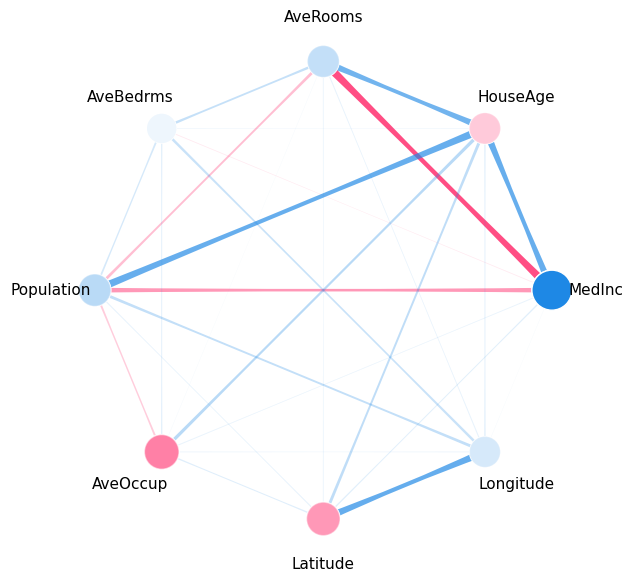

In [7]:
shapiq.network_plot(
    interaction_values=interaction_values_gaussian,
    feature_names=X.columns,
    show=True,
)

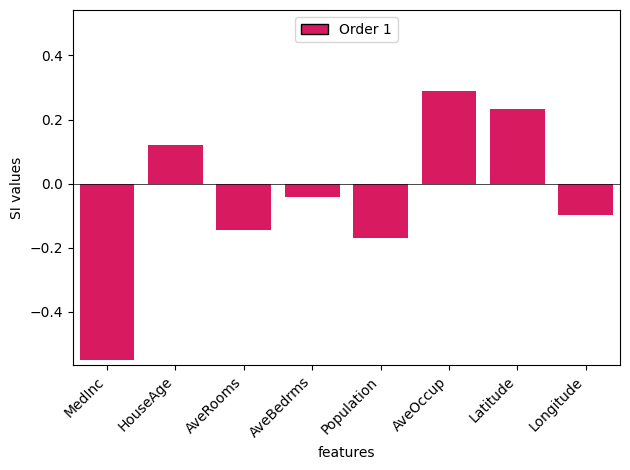

In [8]:
shapiq.stacked_bar_plot(
    interaction_values_gaussian.get_n_order(1),
    feature_names=X.columns,
    show=True,
)

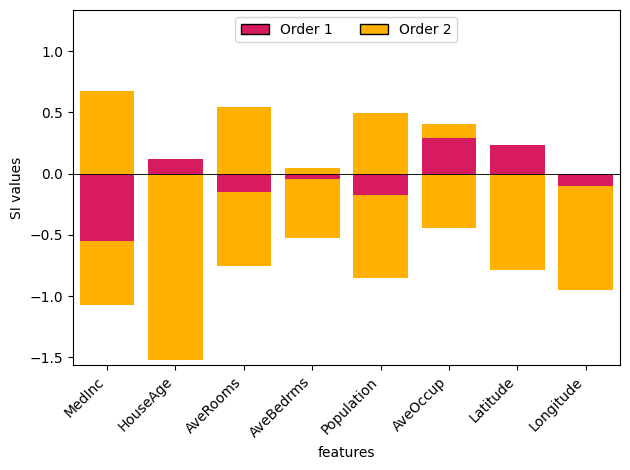

In [9]:
shapiq.stacked_bar_plot(
    interaction_values=interaction_values_gaussian,
    feature_names=X.columns,
    show=True,
)

##### Gaussian Copula
A generalization of the _gaussian_ approach, which is, to represent the marginals of the features by their empirical distributions and then model the dependence structure by a Gaussian distribution. This _copula_ approach generates the $K$ conditional Monte Carlo samples
$x_{\overline{S}}^{(k)} \sim  p(x_{\overline{S}}|x_S = x^{*}_{S})$ with the following routine:

1. Convert each marginal $x_j$ of the feature distribution $x$ to a Gaussian distributed variable $v_j$ by $v_j = Φ^{-1}(\hat{F}(x_j))$,
where $\hat{F}(x_j)$ is the empirical distribution function of $x_j$.
2. Assume that $v$ is distributed according to a _multivariate Gaussian_, and sample from the conditional distribution $p(v_{\overline{S}}|v_{S} = v^{∗}_S)$ using the method described for the gaussian approach.
3. Convert the marginals $v_j$ in the conditional distribution to the original distribution using $\hat{x}_j = \hat{F}^{−1}_j(Φ(v_j))$.

In [11]:
class PredictWrapper:
    def __init__(self, model):
        self.model = model

    def __call__(self, X):
        return self.model.predict(X)


wrapped_model = PredictWrapper(model)

gaussian_copula_imputer = GaussianCopulaImputer(model=wrapped_model, data=X_test)

explainer_copula = shapiq.TabularExplainer(
    # attributes of the explainer
    model=model,
    data=X_train,
    index="SII",
    max_order=2,

    # attributes of the imputer
    imputer=gaussian_copula_imputer,
    sample_size=100,
    conditional_budget=32,
    conditional_threshold=0.04,
)

In [12]:
x_explain_copula = X_test[100]
interaction_values_copula = explainer_copula.explain(x_explain_copula, budget=2**n_features, random_state=0)
print(interaction_values_copula)

InteractionValues(
    index=SII, max_order=2, min_order=0, estimated=False, estimation_budget=256,
    n_players=8, baseline_value=2.0654183865546734,
    Top 10 interactions:
        (0, 2): 0.7884737085054059
        (5,): 0.36069420742112607
        (1,): -0.10597534903944493
        (0, 5): -0.1146493779594047
        (1, 2): -0.1333480004627043
        (7,): -0.15858891564937233
        (6, 7): -0.17065178017924243
        (1, 5): -0.21204539553947788
        (2,): -0.2491285936342
        (0,): -0.34139673483021343
)


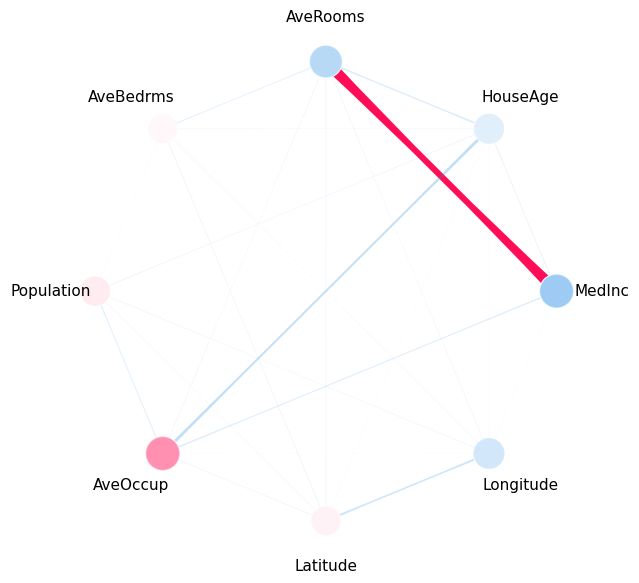

In [13]:
shapiq.network_plot(
    interaction_values=interaction_values_copula,
    feature_names=X.columns,
    show=True,
)

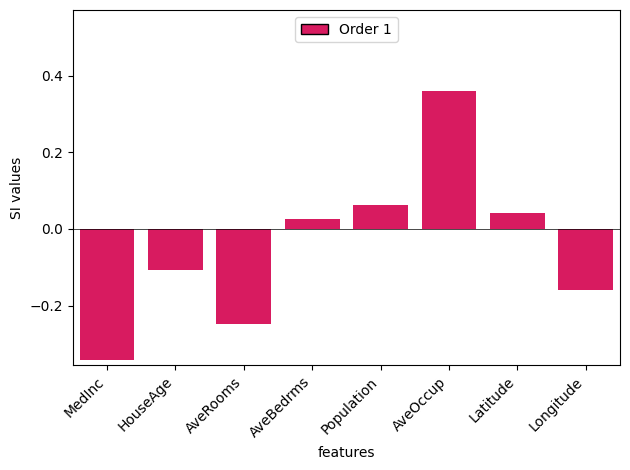

In [14]:
shapiq.stacked_bar_plot(
    interaction_values_copula.get_n_order(1),
    feature_names=X.columns,
    show=True,
)

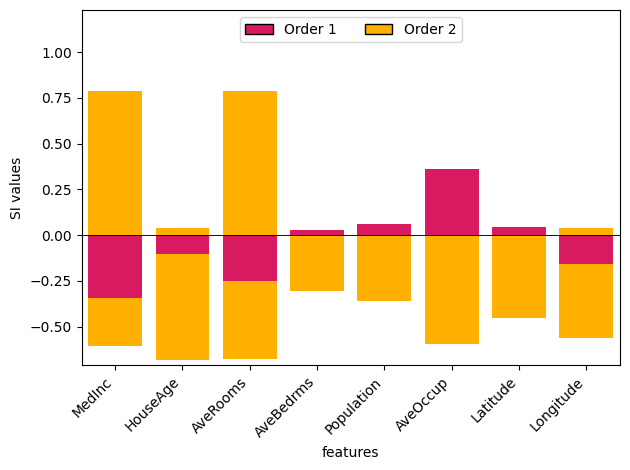

In [15]:
shapiq.stacked_bar_plot(
    interaction_values=interaction_values_copula,
    feature_names=X.columns,
    show=True,
)

Let's compute the global explanations of both `GaussianImputer` and `GaussianCopulaImputer`  using bar plot to have a better grasp of the performance.

In [21]:
from tqdm.asyncio import tqdm

explanations_gaussian = []
for instance_id in tqdm(range(20)):
    x_explain_gaussian = X_test[instance_id]
    si = explainer_gaussian.explain(x=x_explain_gaussian, budget=2**n_features, random_state=0)
    explanations_gaussian.append(si)

100%|██████████| 20/20 [00:01<00:00, 12.39it/s]


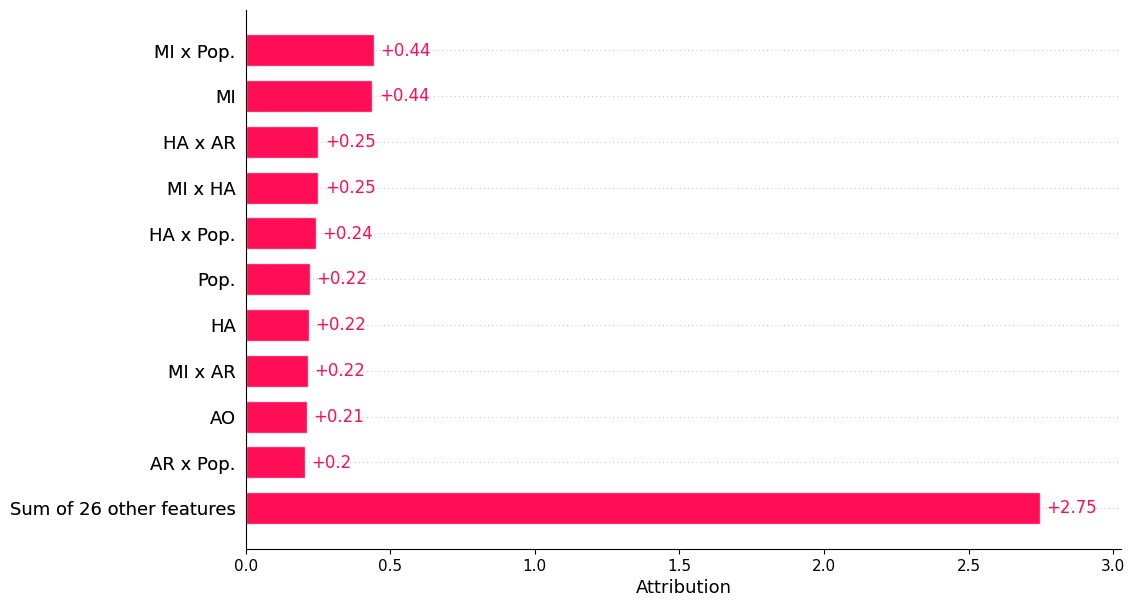

In [22]:
shapiq.plot.bar_plot(explanations_gaussian, feature_names=feature_names, show=True)

In [23]:
explanations_copula = []
for instance_id in tqdm(range(20)):
    x_explain_copula = X_test[instance_id]
    si = explainer_copula.explain(x=x_explain_copula, budget=2**n_features, random_state=0)
    explanations_copula.append(si)

100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


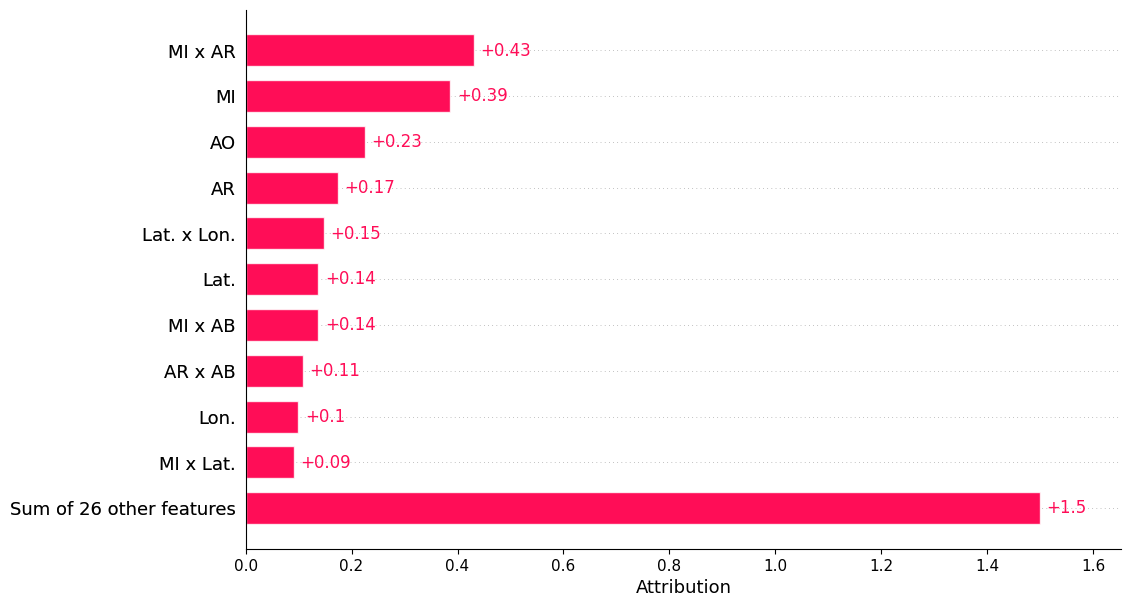

In [25]:
shapiq.plot.bar_plot(explanations_copula, feature_names=feature_names, show=True)

### Analysis
There are two intuitive ways to observe the improvement achieved by the `GaussianCopulaImputer`:
1. The `GaussianCopulaImputer` produces a clearer network plot compared to the `GaussianImputer`, indicating a better capture of feature interactions. This improvement is also reflected in the global explanations bar plot, where positively contributing features are more coherently clustered when using the `GaussianCopulaImputer`.
2. In the global explanations bar plot, the `GaussianImputer` shows a positive interaction between `HouseAge` and `AveRooms`, which is likely inaccurate. In contrast, this interaction does not appear when using the `GaussianCopulaImputer`, suggesting a more reliable representation of the underlying relationships.